# A workflow to find outlier expansions

## Authors in alphabetical order

- [Madeline Couse, SickKids](mailto:madeline.couse@sickkids.ca)
- [Giulia Del Gobbo, CHEO](mailto:gdelgobbo@cheo.on.ca)
- [Egor Dolzhenko, PacBio](mailto:edolzhenko@pacificbiosciences.com)
- [Adam English, BCM](mailto:adam.english@bcm.edu)
- [Tom Mokveld, PacBio](mailto:tmokveld@pacificbiosciences.com)

## Introduction

Suppose that you want to look for repeat expansions in one or more of your case samples relative to a set of controls. Let's assume that you have already aligned the reads, ran TRGT, and merged the results into an allele database file `alleles.gz` that has three columns: repeat id, sample id, and allele sequences. Let's use the next code block to set the path to your allele database and also define ids of case samples.  

## Setup

Create directories for temporary files and the final output:

In [1]:
from pathlib import Path
scratch_path = Path("scratch").mkdir(exist_ok=True)
output_path = Path("output").mkdir(exist_ok=True)

Download sample data containing repeats from chr9 with some (artificially added) expansions      

In [2]:
%%bash

wget -nv -P input/ https://github.com/tandem-repeat-workflows/find-outlier-expansions/raw/main/data/alleles.gz

2023-11-13 13:20:21 URL:https://raw.githubusercontent.com/tandem-repeat-workflows/find-outlier-expansions/main/data/alleles.gz [30384571/30384571] -> "input/alleles.gz" [1]


In [3]:
alleles_path = Path("input/alleles.gz").resolve(strict=True)

case_ids = ["HG00280", "HG00438", "HG00621"] # Assume that all other samples are controls

Now let's confirm that allele database file has the expected structure:

In [4]:
! zcat < {alleles_path} | head -n 3

chr9_100000411_100000479_A	HG00099	AGTGATAAAGCAAGATCCTGTATCAAAAAAAAAAAAAAAAAAACTTTCTCCCTTCTTCAATTTTTTGG,AGTGATAAAGCAAGATCCTGTATCAAAAAAAAAAAAAAAAAACTTTCTCCCTTCTTCAATTTTTTGG
chr9_100000411_100000479_A	HG00280	AGTGATAAAGCAAGATCCTGTATCAAAAAAAAAAAAAAAAAAACTTTCTCCCTTCTTCAATTTTTTGG,AGTGATAAAGCAAGATCCTGTATCAAAAAAAAAAAAAAAAAACTTTCTCCCTTCTTCAATTTTTTGG
chr9_100000411_100000479_A	HG00323	AGTGATAAAGCAAGATCCTGTATCAAAAAAAAAAAAAAAAAACTTTCTCCCTTCTTCAATTTTTTGG,AGTGATAAAGCAAGATCCTGTATCAAAAAAAAAAAAAAAAAAAACTTTCTCCCTTCTTCAATTTTTTGG

gzip: stdout: Broken pipe


## Find outliers

Let's create some code for extracting alleles from the database file.

In [5]:
import gzip
import itertools
import numpy as np
from collections import namedtuple

RepeatRec = namedtuple("RepeatRec", "sample short_allele long_allele")

def get_repeat_recs(path):
    def parse_alleles(group):
        alleles = list(line.decode("utf8").split() for line in group)
        alleles = [(rec[1], rec[2].split(",")) for rec in alleles]
        return alleles
    
    with gzip.open(path, "r") as file:
        for trid, group in itertools.groupby(file, key=lambda line: line.decode("utf8").split()[0]):
            alleles = parse_alleles(group)
            repeat_recs = [(s, [len(a) for a in als]) for s, als in alleles]
            repeat_recs = [RepeatRec(s, min(als), max(als)) for s, als in repeat_recs]
            
            yield trid, repeat_recs

The following code with resample quantiles.

In [6]:
def resample_quantiles(counts, num_resamples):
    """Based on https://github.com/Illumina/ExpansionHunterDenovo/blob/master/scripts/core/common.py"""
    resamples = np.random.choice(counts, len(counts) * num_resamples)
    resamples = np.split(resamples, num_resamples)

    resampled_quantiles = []
    for resample in resamples:
        quantile = np.quantile(resample, 0.95)
        resampled_quantiles.append(quantile)

    return resampled_quantiles


def get_counts_with_finite_std(counts):
    if len(set(counts)) == 1:
        return counts[:-1] + [counts[-1] + 0.1]
    return counts


def get_cutoff(quantiles):
    mean = np.mean(quantiles)
    std = max(1, np.std(quantiles))
    cutoff = mean + std
    return cutoff

In [7]:
HitRec = namedtuple("HitRec", "trid sample allele_type allele_len z_score control_range")

def get_hits(allele_type, repeat_recs):
    assert allele_type in ["long", "short"]
    allele_index = 2 if allele_type == "long" else 1
    cases, controls = {}, []
    for rec in repeat_recs:
        if rec.sample in case_ids:
            cases[rec.sample] = rec[allele_index]
        else:
            controls.append(rec[allele_index])
    quantiles = resample_quantiles(controls, 100)
    quantiles = get_counts_with_finite_std(quantiles)
    cutoff = get_cutoff(quantiles)
    
    for case, allele_len in cases.items():
        mean_control = np.mean(controls)
        std_control = np.std(controls)
        z_score = (allele_len - mean_control) / std_control
        if allele_len > cutoff:
            yield case, allele_len, z_score, (min(controls), max(controls))

hits = []
for i, (trid, repeat_recs) in enumerate(get_repeat_recs(alleles_path)):    
    for hit_type in ["long", "short"]:
        for case, allele_len, z_score, control_range in get_hits(hit_type, repeat_recs):
            hits.append(HitRec(trid, case, hit_type, allele_len, z_score, control_range))

print(f"Found {len(hits)} hits")

/tmp/ipykernel_2923/2885101820.py:19: RuntimeWarning: invalid value encountered in scalar divide
  z_score = (allele_len - mean_control) / std_control
/tmp/ipykernel_2923/2885101820.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  z_score = (allele_len - mean_control) / std_control


Found 1753 hits


In [9]:
import re
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from pandas.api.types import CategoricalDtype
from matplotlib.lines import Line2D 

In [10]:
df = pd.DataFrame(hits)
df[['chrom', 'start', 'end', '_']] = df['trid'].str.split('_', expand=True)
df.drop(columns=['_'], inplace=True)
df['start'] = df['start'].astype(int)
df['end'] = df['end'].astype(int)

# Natural sort by chromosomes and start position
sorted_chromosomes = sorted(df['chrom'].unique(), key=lambda s: [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)])
df = (df.astype({'chrom': CategoricalDtype(categories=sorted_chromosomes, ordered=True)}).sort_values(by=['chrom', 'start']))

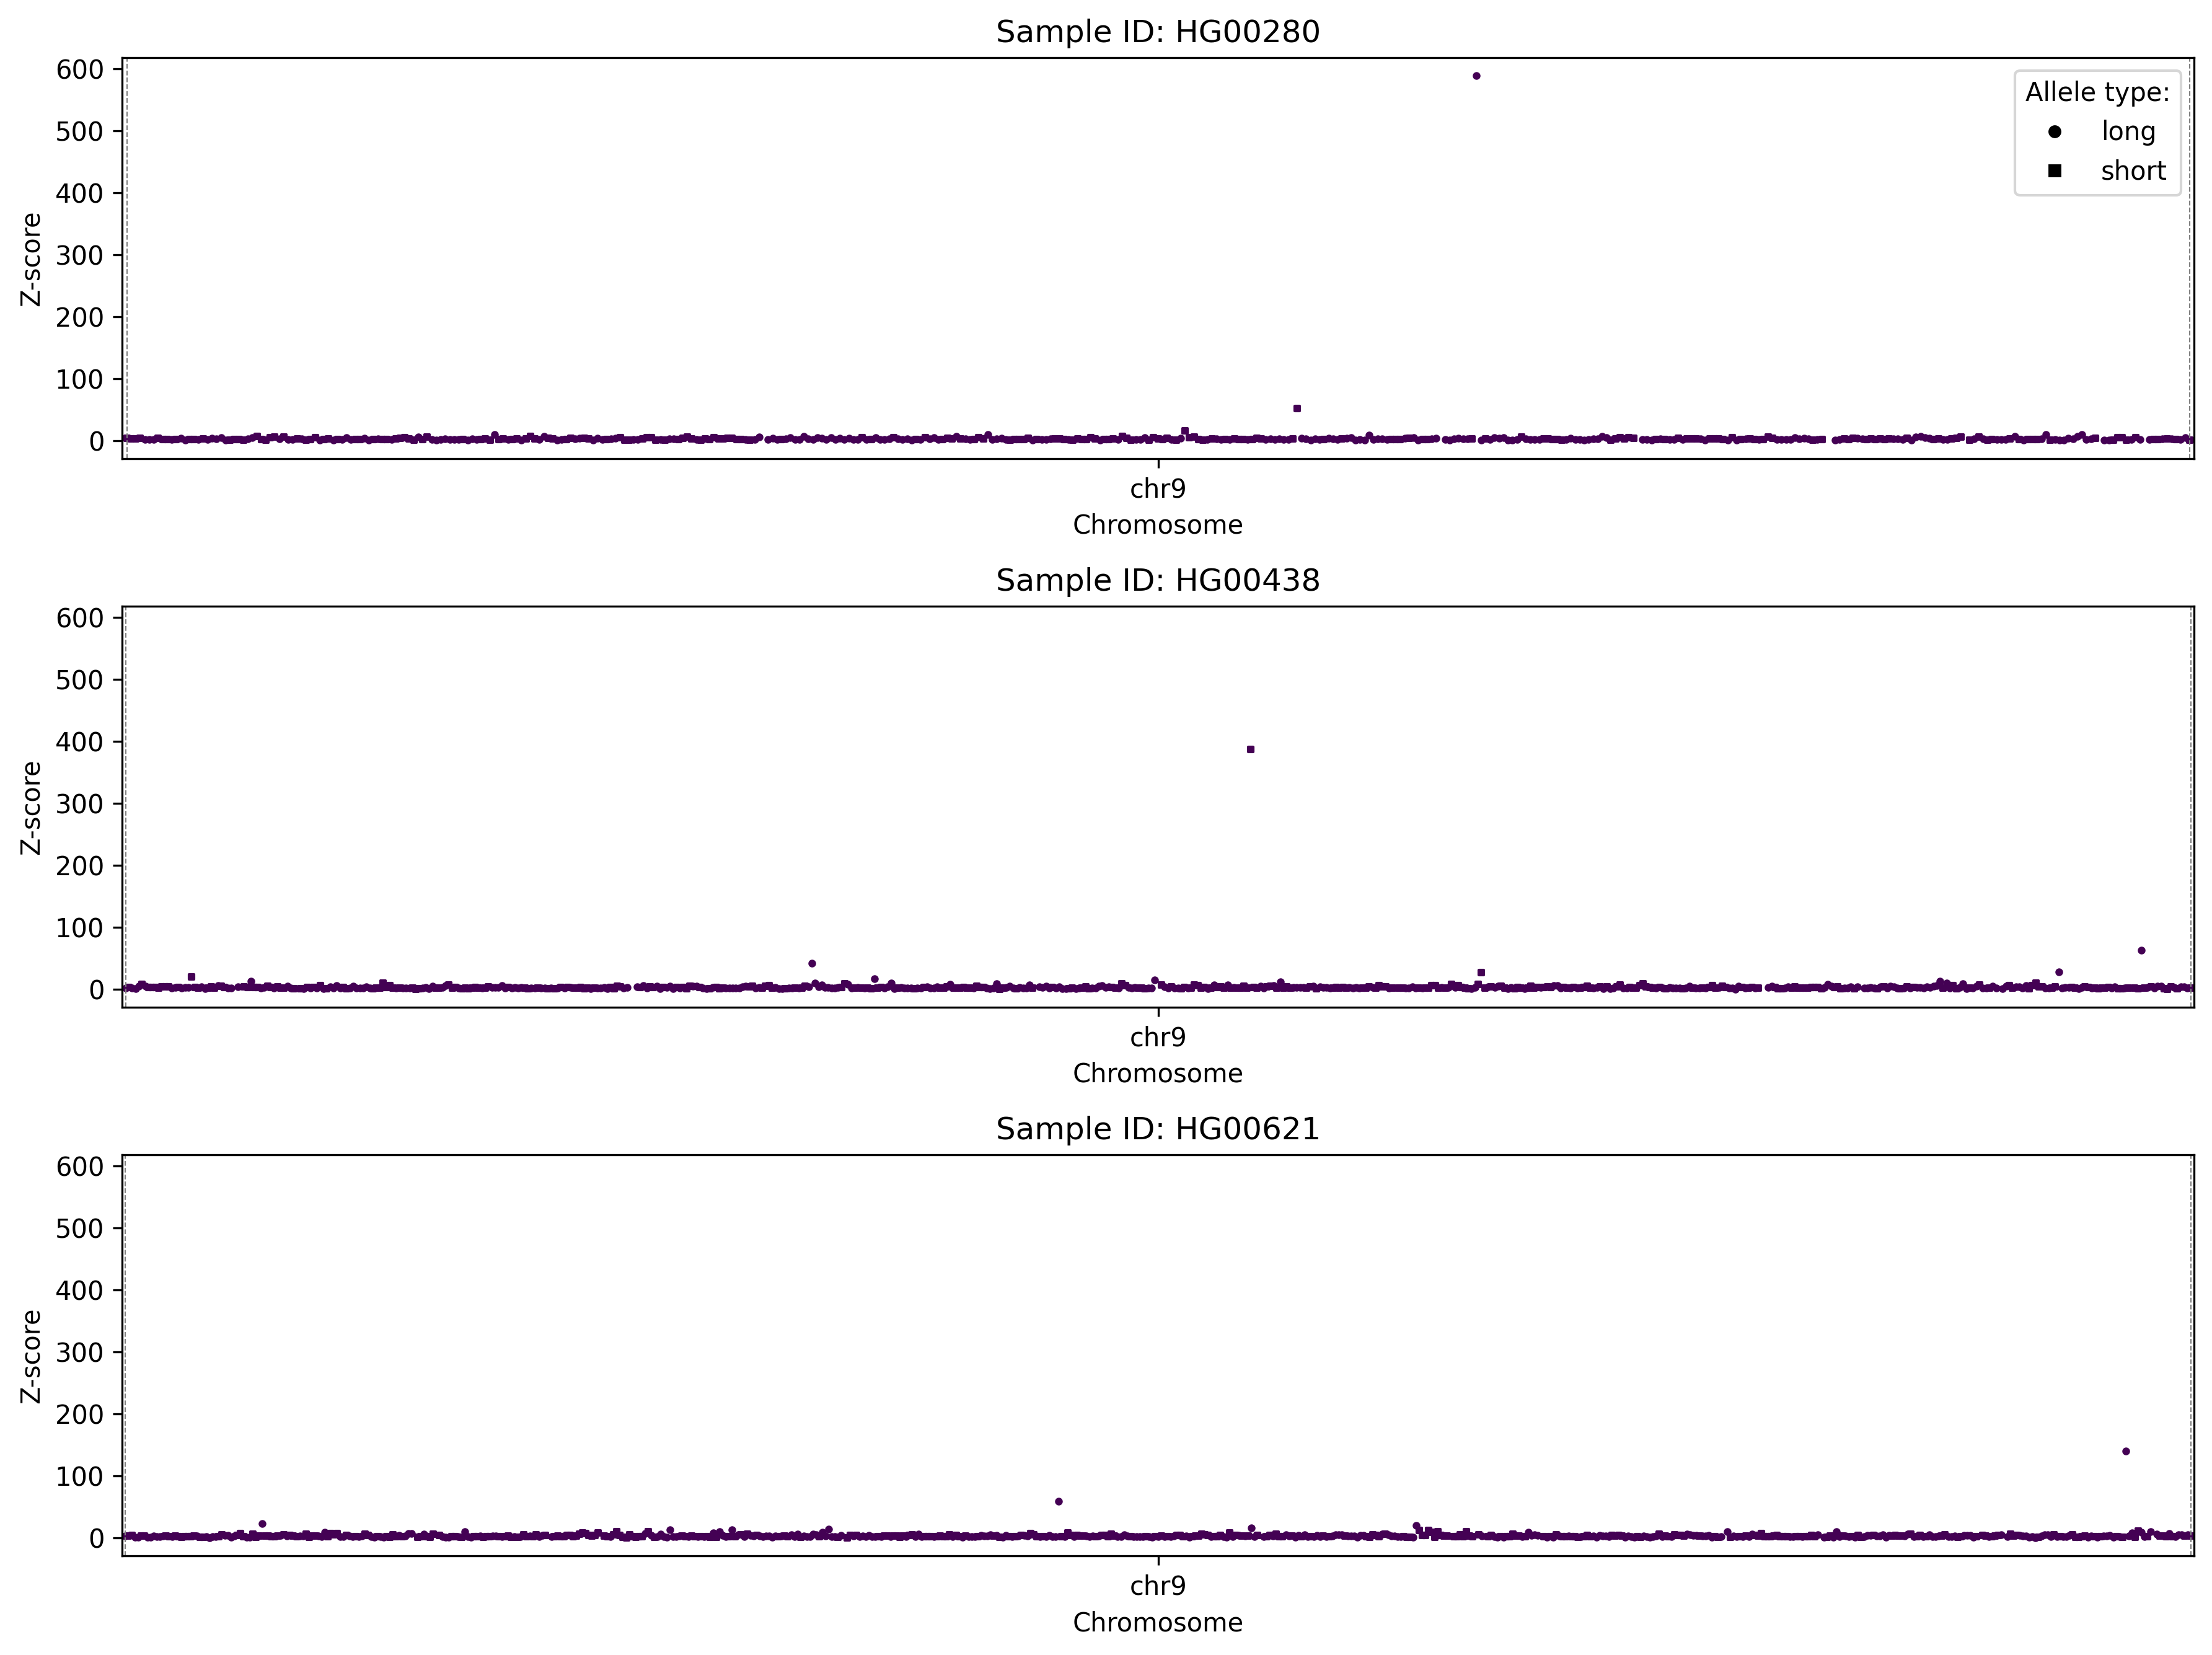

In [11]:
df_grouped_by_sample = df.groupby('sample')
n_samples = len(df['sample'].unique())

fig, axes = plt.subplots(n_samples, 1, figsize=(12, 3 * n_samples), dpi=300, sharey=True)

markers = {'long': 'o', 'short': 's'}
legend_handles = [Line2D([0], [0], marker=marker, color='w', markerfacecolor='black', markersize=6) for marker in markers.values()]
legend_labels = [str(allele) for allele in markers.keys()]

for ax_idx, (ax, (sample_id, df_sample))  in enumerate(zip(axes, df_grouped_by_sample)):
    df_sample_grouped = df_sample.groupby('chrom')
    colormap = matplotlib.colormaps['viridis'].resampled(len(df_sample_grouped))
    
    x_labels = []
    x_labels_pos = []
    line_positions = []
    df_sample['ind'] = range(len(df_sample))
    
    for i, (name, group) in enumerate(df_sample_grouped):
        if group.empty:
            continue
            
        for allele_type, marker_style in markers.items():
            allele_group = group[group['allele_type'] == allele_type]
            if allele_group.empty:
                continue
            allele_group.plot(kind='scatter', x='ind', y='z_score', color=colormap(i), s=4, ax=ax, marker=marker_style)
                
        x_labels.append(name)
        mid_pos = (group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0]) / 2)
        x_labels_pos.append(mid_pos)
        line_positions.append(group['ind'].iloc[0])
        
    line_positions.append(group['ind'].iloc[-1])    
    for pos in line_positions:
        ax.axvline(x=pos, color='grey', linestyle='--', linewidth=0.5)

    if ax_idx == 0:
        ax.legend(legend_handles, legend_labels, title='Allele type:', loc='best')
    
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    ax.set_xlim([-1, len(df_sample)])
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('Z-score')
    ax.set_title(f'Sample ID: {sample_id}')
    # ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [11]:
df.sort_values(['z_score'], ascending=False).head()

,trid,sample,allele_type,allele_len,z_score,control_range,chrom,start,end
654,chr9_136450174_136450265_AAAC,HG00621,short,95,inf,"(91, 91)",chr9,136450174,136450265
1033,chr9_35494000_35494083_TTTA,HG00438,short,87,inf,"(83, 83)",chr9,35494000,35494083
822,chr9_20639997_20640072_TTTTGTT,HG00621,long,77,inf,"(75, 75)",chr9,20639997,20640072
808,chr9_19948949_19949030_ATTT,HG00621,long,85,inf,"(81, 81)",chr9,19948949,19949030
319,chr9_117367479_117367554_GT,HG00280,long,77,inf,"(75, 75)",chr9,117367479,117367554


# Annotate outliers

In [16]:
import pyranges as pr

In [38]:
def pivot_hits(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert hits dataframe from long to wide format so each sample is associated with two columns:
    [sample]_allele_len, and [sample]_z_score
    """
    hits = df.copy()
    hits["trid"] = hits["trid"] + "_" + hits["allele_type"]
    hits = hits.drop("allele_type", axis=1)
    hit_pivot = hits.pivot(
        index=["trid", "control_range"],
        columns="sample",
        values=["allele_len", "z_score"],
    ).reset_index()

    hit_pivot.columns = (
        hit_pivot.columns.get_level_values(1)
        + "_"
        + hit_pivot.columns.get_level_values(0)
    )
    hit_pivot = hit_pivot.rename(
        columns={"_trid": "trid", "_control_range": "control_range"}
    )

    return hit_pivot


def hits_to_pr(hits: pd.DataFrame) -> pr.PyRanges:
    """
    Convert hits dataframe to PyRanges object
    """
    hits["Chromosome"] = hits["trid"].map(lambda x: x.split("_")[0].replace("chr", ""))
    hits["Start"] = hits["trid"].map(lambda x: x.split("_")[1])
    hits["End"] = hits["trid"].map(lambda x: x.split("_")[2])
    hit_pr = pr.PyRanges(hits)

    return hit_pr


def prepare_Ensembl_GTF(gtf_path: str, cols: list) -> pr.PyRanges:
    """
    Convert GTF file into a PyRanges object and clean up columns
    """
    ensembl_gr = pr.read_gtf(gtf_path)[cols]
    introns = ensembl_gr.features.introns(by="gene")
    ensembl_gr = pd.concat([ensembl_gr.df, introns.df], ignore_index=True)
    features = ["exon", "three_prime_utr", "five_prime_utr", "intron"]
    ensembl_gr = ensembl_gr[ensembl_gr.Feature.isin(features)]

    return ensembl_gr


def prepare_TRGT_loci(loci_path: str) -> pr.PyRanges:
    """
    Convert repeat loci derived from TRGTdb into a PyRanges object
    """
    loci = pd.read_csv(loci_path).rename(
        {"chrom": "Chromosome", "end": "End", "start": "Start"}, axis=1
    )
    # remove chr prefix from chromosomes for compatibility with gene table
    loci["Chromosome"] = loci["Chromosome"].apply(lambda chrom: chrom.strip("chr"))
    loci_gr = pr.PyRanges(loci)

    return loci_gr


def annotate_genes(loci: pr.PyRanges, genes: pr.PyRanges) -> pd.DataFrame:
    """
    Annotate loci against Ensembl genes
    """
    loci_ensembl = loci.join(
        genes, suffix="_ensembl", how="left", apply_strand_suffix=False
    ).drop(["Start_ensembl", "End_ensembl", "Strand"])
    loci_ensembl_df = loci_ensembl.df
    loci_ensembl_df["gene_name"] = np.where(
        loci_ensembl_df["gene_name"].isnull(), "-1", loci_ensembl_df["gene_name"]
    )

    return loci_ensembl_df


def add_constraint(constraint: pd.DataFrame, hits_gene: pd.DataFrame) -> pd.DataFrame:
    """Add transcript-specific gnomAD v4 LOEUF and pLI scores"""
    hits_gene = hits_gene.merge(constraint, left_on="gene_name", right_on="gene", how="left")

    return hits_gene
    

def group_by_gene(hits_gene: pd.DataFrame) -> pd.DataFrame:
    """
    One hit may be associated with multiple gene features and so multiple rows
    Aggregate by gene and join features to remove duplicate rows
    """
    gene_cols = ["gene_name", "gene_id", "gene_biotype", "Feature", "lof.oe_ci.upper", "lof.pLI"]

    hits_gene_dedup = hits_gene.groupby(["trid"]).agg(
        {
            "gene_name": ";".join,
            "gene_id": ";".join,
            "gene_biotype": ";".join,
            "Feature": ";".join,
            "lof.oe_ci.upper": min,
            "lof.pLI": max,
        }
    )
    # merge with original loci table
    hits_gene = hits_gene.drop(gene_cols, axis=1)
    hits_gene_merged = hits_gene.merge(hits_gene_dedup, on=["trid"], how="left")
    hits_gene_merged_dedup = hits_gene_merged.drop_duplicates()

    return hits_gene_merged_dedup


def prepare_OMIM(mim2gene_path: str, morbidmap_path: str) -> pd.DataFrame:
    """
    Merge OMIM mim2gene table with morbidmap table to associate phenotypes to genes.
    See omim.org/downloads for download access to these files.
    """
    mim2gene = pd.read_csv(
        mim2gene_path,
        sep="\t",
        comment="#",
        names=[
            "MIM_Number",
            "MIM_Entry_Type",
            "Entrez_Gene_ID",
            "HGNC_symbol",
            "Ensembl_gene_ID",
        ],
    ).set_index("MIM_Number")
    morbidmap = pd.read_csv(
        morbidmap_path,
        sep="\t",
        comment="#",
        names=["Phenotype", "Gene_Symbols", "MIM_Number", "Cyto_Location"],
    ).set_index("MIM_Number")

    gene2mim = morbidmap.join(mim2gene, how="left")
    gene2mim = gene2mim[gene2mim["MIM_Entry_Type"].str.contains("gene")].drop(
        [
            "Gene_Symbols",
            "Cyto_Location",
            "MIM_Entry_Type",
            "Entrez_Gene_ID",
            "HGNC_symbol",
        ],
        axis=1,
    )
    # remove genes that are not associated with any phenotype and rename columns
    gene2mim = gene2mim[gene2mim["Phenotype"].notna()].rename(
        {"Phenotype": "OMIM_phenotype", "Ensembl_gene_ID": "gene_id"}, axis=1
    )
    # group phenotypes by gene and aggregate phenotypes so that there is one row per gene:
    gene2mim = (
        gene2mim.groupby("gene_id")[["OMIM_phenotype"]]
        .agg({"OMIM_phenotype": (";").join})
        .reset_index()
    )

    return gene2mim


def annotate_OMIM(loci_ensembl: pd.DataFrame, omim: pd.DataFrame) -> pd.DataFrame:
    """
    Annotate loci against OMIM phenotypes. Loci must already be annotated against Ensembl genes.
    """
    loci_ensembl_omim = loci_ensembl.merge(omim, how="left", on="gene_id")
    loci_ensembl_omim["OMIM_phenotype"] = loci_ensembl_omim["OMIM_phenotype"].fillna(
        "-1"
    )

    return loci_ensembl_omim


def gene_set(genes: str) -> str:
    """
    Reduce semi-colon separate gene identifiers to unique gene identifiers
    """
    genes = ";".join(list(set(genes.split(";"))))
    return genes

In [39]:
# convert hits dataframe from long to wide format
df = pd.DataFrame(hits)
hits_pivot = pivot_hits(df)
hits_pr = hits_to_pr(hits_pivot)

In [20]:
# code to download GRCh38 GTF file
# %%bash
# wget https://ftp.ensembl.org/pub/release-109/gtf/homo_sapiens/Homo_sapiens.GRCh38.109.chr.gtf.gz
# mv Homo_sapiens.GRCh38.109.chr.gtf.gz ../annotations

In [ ]:
# code to download gnomAD constraint
# %%bash
# wget https://storage.googleapis.com/gcp-public-data--gnomad/release/v4.0/constraint/gnomad.v4.0.constraint_metrics.tsv
# mv gnomad.v4.0.constraint_metrics.tsv ../annotations/

In [43]:
# prep Ensembl gene GTF
cols = ["gene_name", "gene_id", "gene_biotype", "Feature"]
gene_gr = prepare_Ensembl_GTF(
    "../annotations/Homo_sapiens.GRCh38.109.chr.gtf.gz", cols=cols
)

In [44]:
# annotate hits with Ensembl genes
hits_gene = annotate_genes(hits_pr, pr.PyRanges(gene_gr))

# annotate with gene constraint
constraint_cols = ["gene", "lof.oe_ci.upper", "lof.pLI"]
constraint = pd.read_csv("../annotations/gnomad.v4.0.constraint_metrics.tsv", sep="\t")[constraint_cols].dropna()
hits_gene = add_constraint(constraint, hits_gene)

# group and aggregate gene columns
hits_gene = group_by_gene(hits_gene)

# annotate with OMIM
omim = prepare_OMIM("../annotations/mim2gene.txt", "../annotations/morbidmap.txt")
hits_gene_omim = annotate_OMIM(hits_gene, omim)


# make a column with maximum z score across samples
z_score_cols = [col for col in hits_gene_omim.columns if "z_score" in col]
for col in z_score_cols:
    hits_gene_omim[col] = [
        round(score, 3) if not pd.isnull(score) else None
        for score in hits_gene_omim[col]
    ]
hits_gene_omim["max_z_score"] = hits_gene_omim[z_score_cols].max(axis=1)

# make a column that sums the number of individuals carrying a particular repeat expansion
al_cols = [col for col in hits_gene_omim.columns if '_allele_len' in col]
hits_gene_omim['num_samples'] = hits_gene_omim[al_cols].notna().sum(axis=1)

# column cleanup
for col in ["gene_name", "gene_id", "gene_biotype", "Feature"]:
    hits_gene_omim[col] = hits_gene_omim[col].apply(lambda genes: gene_set(genes))

hits_gene_omim = hits_gene_omim[
    [
        "Chromosome",
        "Start",
        "End",
        "trid",
        "gene_name",
        "gene_id",
        "gene_biotype"]
        + constraint_cols
        + [
        "Feature",
        "control_range",
        "max_z_score",
        "num_samples"
    ]
    + al_cols
    + z_score_cols
    + ["OMIM_phenotype"]
]
hits_gene_omim = hits_gene_omim.rename(
    columns={"Feature": "feature", "Chromosome": "chr", "Start": "start", "End": "end", "gene": "gnomad_constraint_gene"}
)

# recode missing values
hits_gene_omim["chr"] = hits_gene_omim["chr"].astype(str)
hits_gene_omim.fillna(".", inplace=True)
hits_gene_omim.replace({"-1": "."}, inplace=True)